In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Gaussian

In [6]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    AtomicNumberWeighted, Gaussians
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, RADIAL_GAUSSIAN_MODELS, AZIMUTHAL_GAUSSIAN_MODELS, POLAR_GAUSSIAN_MODELS
    
radial_gaussians = Gaussians(*RADIAL_GAUSSIAN_MODELS["Equidistant-Broadening_1"])
    
descriptor = AtomicNumberWeighted(
    radial_gaussians,
    Gaussians(*AZIMUTHAL_GAUSSIAN_MODELS["Equisitant_1"]),
    Gaussians(*POLAR_GAUSSIAN_MODELS["Equisitant_1"])
)


def make_descriptor(molecule, atom_ind):
    
    return descriptor.calculate_atom_descriptor(
        atom_ind, 
        molecule,
        descriptor.number_of_descriptors
    )

# Display Gaussians

In [109]:
from SCFInitialGuess.descriptors.coordinate_descriptors import behler_cutoff_1

def evaluate_gaussian(x, r_s, eta, R_c):
    return np.exp(-1 * eta*(x - r_s)**2) *  behler_cutoff_1(x, R_c)

def calculate_inverse_descriptor(descriptor_values, centers, widths, R_c, t=None):
    
    if t is None:
        t = np.linspace(0, R_c, 100)
    
    ret = 0
    for v, c, w in zip(descriptor_values, centers, widths):
        ret += v * evaluate_gaussian(t, c, w, R_c)
    return ret

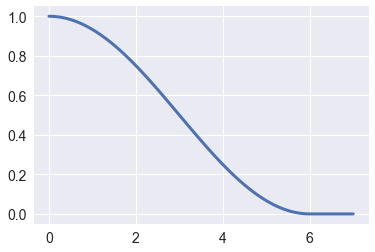

In [92]:
x = np.linspace(0, 7, 100)
plt.plot(x, behler_cutoff_1(x, 6))

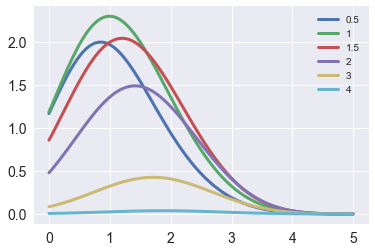

In [93]:
x = np.linspace(0, radial_gaussians.R_c, 100)

for i in [0.5, 1, 1.5, 2, 3, 4]:
    plt.plot(x, calculate_inverse_descriptor(
        radial_gaussians.calculate_descriptor(i), ## for every value placed here, the peak should be the same
        radial_gaussians.r_s,
        radial_gaussians.eta,
        radial_gaussians.R_c
    ),
    label=str(i)
    )
plt.legend()
plt.show()

Klar sichtbar: peaks sind viel zu breit!!!! und positionen können ganz klar, NICHT aufgelöst werden!!

# New Gaussians

In [94]:
def plot_model(model):
    R_c, mus, sigmas = model
    t = np.linspace(0, R_c, 100)
    
    for r_s, eta in zip(mus, sigmas):
        plt.plot(t, evaluate_gaussian(t, r_s, eta, R_c))

## Forward

In [97]:
mymodel = (
    5,
    [0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0],
    [3.0, 2.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.8, 1.5]
)

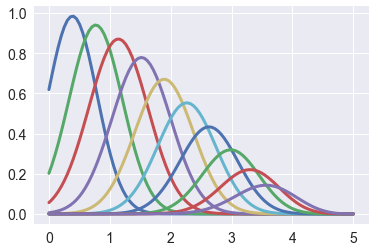

In [98]:
plot_model(mymodel)

## Backprop

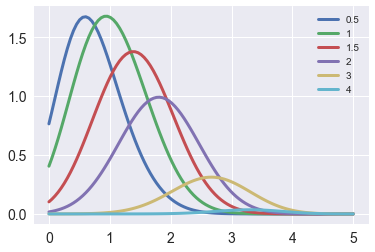

In [110]:
x = np.linspace(0, radial_gaussians.R_c, 100)

model_descriptor = Gaussians(*mymodel)

for i in [0.5, 1, 1.5, 2, 3, 4]:
    plt.plot(x, calculate_inverse_descriptor(
        model_descriptor.calculate_descriptor(i), ## for every value placed here, the peak should be the same
        model_descriptor.r_s,
        model_descriptor.eta,
        model_descriptor.R_c,
        t=x
    ),
    label=str(i)
    )
plt.legend()
plt.show()

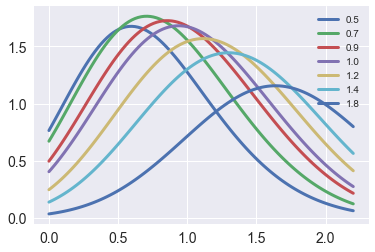

In [111]:
x = np.linspace(0, 2.2, 100)

model_descriptor = Gaussians(*mymodel)

for i in [0.5, 0.7, 0.9, 1.0, 1.2, 1.4, 1.8]:
    plt.plot(x, calculate_inverse_descriptor(
        model_descriptor.calculate_descriptor(i), ## for every value placed here, the peak should be the same
        model_descriptor.r_s,
        model_descriptor.eta,
        model_descriptor.R_c, 
        t=x
    ),
    label=str(i)
    )
plt.legend()
plt.show()

Fazit: diese vielen Gaussians ergeben jetzt halbwegs an den punten ein maximum an dem eine Erregung abgetastet wurde

# Anregungs surf

Im punkt r= 2 phi = 2 wird eine anregung hinein gesetzet. Mal schauen ob die das Reproduzieren können.

In [113]:
r = np.linspace(0, 5, 20)
phi = np.linspace(- np.pi, np.pi, 20)

R, Phi = np.meshgrid(r, phi)

In [156]:
def activation(r, phi, values_radial, radial_model, values_angular, angular_model):
    
    ret_radial = 0
    for v_rad, r_s_rad, eta_rad in zip(values_radial, radial_model[1], radial_model[2]):
        ret_radial += v_rad * evaluate_gaussian(r, r_s_rad, eta_rad, radial_model[0]) 
    
    ret_ang = 0
    for v_ang, r_s_ang, eta_ang in zip(values_angular, angular_model[1], [angular_model[2]]*len(angular_model[1])):
        ret_ang += v_ang * evaluate_gaussian(phi, r_s_ang, eta_ang, angular_model[0])

    return ret_radial * ret_ang

In [135]:
mymodel[2]

[3.0, 2.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.8, 1.5]

In [210]:
# anregung bei r=3 und r= 0.8
radial_value = np.array(model_descriptor.calculate_descriptor(2)) + \
    0.5 * np.array(model_descriptor.calculate_descriptor(1)) + \
    15.0 * np.array(model_descriptor.calculate_descriptor(4))
    
# anregung bei phi = 2
angular_value = Gaussians(*POLAR_GAUSSIAN_MODELS["Equisitant_1"]).calculate_descriptor(2)

In [211]:
z = activation(
    R, 
    Phi,
    radial_value,
    mymodel,
    angular_value,
    POLAR_GAUSSIAN_MODELS["Equisitant_1"]
)

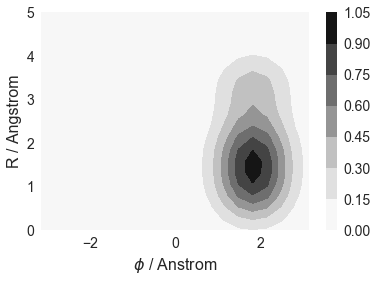

In [212]:
plt.contourf(Phi, R, z)
plt.ylabel("R / Angstrom")
plt.xlabel("$\phi$ / Anstrom")
plt.colorbar()

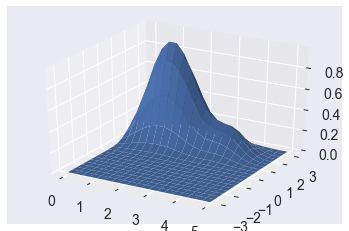

In [197]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(R, Phi, z)
plt.show()

TODOs:
Mehrer ANregungne müssen separat erkennbar sein (zumindest muss es da ein bisschen anregung geben!!!